# Basics of parallel and distributed computing with DASK

## Recap on task parallelization (this time using Dask)

We should now start to feel quite familiar with the programming pattern already discussed in the previous lectures when we discussed Hadood MapReduce and the Spark framework.

Asides from the details of the API, which depend on the framework implementation, and from the inner structure of the job scheduling and resorce manager, most of the distributed computing frameworks and tools offer ways of parallelizing our jobs by means of Graph schedulers and Task optimizers.

The workflow is mostly the same, no matter the tool used to reach it:
- **Divide large datasets which won't fit into memory in a set of partitions**
- **Plan the entire data processing before execution and optimize it to break it into smaller tasks**
- **Schedule and distribute processing near the data, minimizing data movement (data locality)**

In Dask, we still have access to a set of dataset representations:
- Dask bag (~ equivalent to the _Spark RDD_)
- Dask array
- Dask dataframe (~ equivalent to the _Spark DataFrame_)

However, Dask is primarily a **scheduler** (written in Python instead of Scala like Spark \[*\]), which enables _lazy_ execution of python-like code for distributing it across multiple workers.


_\[*\] Note that the fact that Dask's scheduler is written in Python does not necessarily make it better than Spark for our purposes. Python and Scala/Java have their own pros and cons. For example, due to the way Python handles and manages memory during application execution, Dask still has issues with unmanaged memory throughout an application's life cycle (for more information, see this [link](https://coiled.io/blog/tackling-unmanaged-memory-with-dask/))._

## Starting a cluster

We can use Dask locally to leverage the multitasking/processing capabilities of our local machine, or we can set up a cluster and deploy a scheduler and multiple worker nodes.

Once we set up a cluster, we can initialize a `Client` by providing it with the address of a scheduler.

In [1]:
# import the dask distributed client
from dask.distributed import Client

# instantiate the client by providing 
# the address:port of the scheduler
client = Client('dask-scheduler:8786')

# inspect the client
client

<Client: 'tcp://172.18.0.2:8786' processes=3 threads=3, memory=1.43 GiB>

We can monitor the status of the cluster with a dedicated webui by accessing the location (IP address) of the scheduler/master node at port `8787`.
Using Docker with the appropriate port-mapping (provided in the Docker compose file) we can access the dashboard on `localhost:8787`.

The dashboard provides an overview of both the status of the workers, and the execution of the DAG task graphs (when we begin using them).

## Simple parallelization of python functions

_In the following, we will follow a similar approach to the one provided by the excellent Dask documentation._

The simplest example of parallelizing any arbitrary Python code in Dask can be demonstrated with a couple of simple operations, represented by two functions and an arbitrary sleep time of 1 second.

_The sleep time is meant to represent arbitrarily complex code (___your___ task) and the time required for its execution._

In [ ]:
from time import sleep

# dummy function incrementing the input value by 1
def increment(x):
    # sleep for 1s
    sleep(1)
    # given the input x, return x+1
    return x + 1

# dummy function decrementing the input value by 1
def decrement(x):
    # sleep for 1s
    sleep(1)
    # given the input x, return x-1
    return x - 1

# dummy function summing two input values
def add(x, y):
    # sleep for 1s
    sleep(1)
    # given the inputs x and y, return x+y
    return x + y

These are purely Python functions...

We can test the functions locally by running them on the client (not on the cluster).

In [ ]:
%%time
# we should expect a wall-time of roughly 3 seconds (3x 1sec sleep)
x = increment(1)
y = decrement(2)
z = add(x, y)

In order to let Dask take advantage of the processing units assigned to the cluster, we have to let it elaborate the DAG corresponding to the execution of the code we want to deploy on the cluster, and then let the scheduler dispatch the tasks to the workers.

This is done in Dask by declaring that a function is `delayed`.

The `delayed` Dask method takes two main arguments. 
- The first argument is the function that has to be executed in parallel.
- The following arguments are the arguments onto which the original function will apply.

We now want to transform the `increment`, `decrement` and `add` functions, therefore making them **lazy**.

In [10]:
# import the dask delayed module
from dask import delayed

In [ ]:
%%time

# make the function behave as lazy with delayed
#
# result = delayed(your_function)(<your_function_arguments>)
x = delayed(increment)(1)
y = delayed(decrement)(2)
z = delayed(add)(x, y)

At this stage, as usual with lazy operations, we don't have the results stored in `z`.

`z` at this stage is just the "plan" of the code execution, made by the DAG task scheduler.

We can visualize the plan of the execution with the `visualize()` method (we'll need to have the `graphviz` python package installed for this).

In [ ]:
# dask offers a nice and simple 
# visualization of the DAG
z.visualize()

This is the visualization of the task graph **before** any degree of optimization is applied.

We can also ask Dask to provide the DAG **after** the optimization, by using the option `optimize_graph=True`.

We should not expect a lot of optimization for this simple task... but for more complex tasks, we will see a sizeable difference.

In [ ]:
# optimized DAG
z.visualize(optimize_graph=True)

Alternatively, Dask also provides a high-level task visualization tool that can be accessed by clicking on it from a Jupyter notebook.

In [ ]:
# high-level task graph
z.dask

In order to **actually** execute the job, we have to ask Dask to trigger the execution, by asking to return the results of the lazy operation with the `compute()` method.

Under the carpet, Dask will ship the computational graph to the scheduler, and will dispatch the tasks to the workers, similarly to what already discussed for Spark.

It's worth noting that `compute()` is a *blocking* operation, which means that the program will wait for the results to be computed before continuing.

In [ ]:
%%time

# the execution time should now be 
# less than the 3 seconds measured above
# 
# ideally, we should expect 2 seconds:
#  - 1 second (sleep time) to run the increment and decrement functions --in parallel--
#  - 1 second (sleep time) to run the add function based on the results of the previous stages
z.compute() 

## Futures and Eager computation with `submit`

The _eager_ operation alternative to `delayed` in Dask is the `submit`.

This will instruct Dask to submit our task on the cluster right away, and start executing it on the available computing resources.

It is pretty much similar (almost equivalent even) what we have seen with the idea of a _batch system_.

In [ ]:
# submit the function increment with argument 1
# return a "promise" of getting the actual result
future = client.submit(increment, 1)

The function `increment` with its agurment `1` is submitted to the cluster, and the `future` object is returned immediately, but it doesn't contain the result of the computation. 

The `submit` operation has in fact returned a so-called execution ***promise*** (the `future` variable) of the instruction that we have submitted.
It doesn't necessarily mean that the execution has been completed, as the cluster might take some time to execute it.

The `future` variable in fact **doen not contains the result**, but just the promise of it, when the elaboration will be completed. 

**The result of the computation will be left on the worker nodes of our cluster, and will not be sent back to our client until we reclaim it.**

This is extremely important (and useful) when the result of a computation is itself very large, and/or when you will need to execute further tasks on the data resulting from the results of the previous task. 

In the case we want to retrieve the result from the cluster to the client we can invoke the `gather` function on the `future` object.

In [ ]:
# the promise of the result
future

In [ ]:
# the result, gathered from the cluster
client.gather(future)

This approach can be extremely useful in situations where we need to submit a task multiple times, perhaps with different input parameters. 

This is a quite frequent scenario in machine learning, for example when we need to optimize an algorithm for a particular dataset over the hyper-parameter space. 

The idea behind this approach allows us to `map` the instruction that we want to execute to each argument of a dataset, thus submitting the same operation on the entire dataset.

_Practically speaking, we are parallelizing our function in the same exact way we have done with the Python `multiprocessing` module, but on a large and horizontally scalable set of computing resources._

In [ ]:
# restart from a list of integers
data = [0, 1, 2, 3, 4, 5, 6, 7, 8]

# submit the increment function on ALL elements of the list
# using a `map` approach (each element is independent from the others)
future_results = client.map(increment, data)

# this execution is Eager and Asynchronous  
future_results

In [ ]:
# retrieve the data from the cluster
new_data = client.gather(future_results)

print(new_data)

`client.map` is **asynchronous**, i.e. the cluster will compute the results without blocking our local Python code for the taks completion.

_Remember the idea of `process.start()` and `process.join()` in multiprocessing..._

**If** we need to wait for the result of a `submit` computation to be ready (for example, if we need it as an input for other computations), we can use the `wait` method to block the execution of the new code and wait for the computation of the future.

In [ ]:
# import the dask wait 
from dask.distributed import wait

# start the computation
new_future = client.map(increment, new_data)

# block this python process 
# and wait for the remote task to be completed
wait(new_future)

In [ ]:
# the result, gathered from the cluster
client.gather(new_future)

In complete analogy to what we have discussed with the `delayed` lazy execution, we can combine multiple instruction that have to be submitted to the cluster and create a more complex job to run on our cluster.

We should remember that the results of the `submit` execution reside on the cluster until a `gather` is used.

This means that **we can submit a task that takes as argument an execution promise** of an instruction that has been previosly submitted.

The `gather` function should be invoked at the end of the program, only when the results have to be effectively retrieved from the cluster.

In [ ]:
# submit the increment function
x = client.submit(increment, 1)
# submit the decrement function
y = client.submit(decrement, 2)

# submit the add function
#
# this will run on the promises of the results 
# of both the x and y (possibly not yet available)
total = client.submit(add, x, y)

In [ ]:
# this is still the execution promise
print(total)          

In [ ]:
# this is the final result
client.gather(total)  

## Exercise 1: Parallelization of a for loop

At this point, with the previous knowledge of what discussed with Spark, and the `delayed` and `compute` Dask operations, we should already be able to run simple "dummy" tasks.

Starting from a list $\vec{x}$ of values:
1. write a function to increment each element $x_i$ by a random value $\delta x_i$ (in the 0-1 range)
2. write a function to multiply the resulting value by 10
3. loop over $\vec{x}$ and apply both functions on each $x_i$ element using the `delayed`
4. retrieve the sum of all the new updated elements
5. visualize the task graph

In [ ]:
import random
import time

# input data
data = [1, 2, 3, 4, 5, 6, 7, 8]

# increment function
def add_rand(x):
    return x+random.random()

# multiplication function
def mult_ten(x):
    return x*10

# placeholder for the updated array
results = []

# for each element
#  - add a random value
#  - multiply by ten
#  - append the new data in a list
for x in data:
    y = delayed(add_rand)(x)
    z = delayed(mult_ten)(y)
    results.append(z)
    
# sum all elements of the list
total = delayed(sum)(results)

In [ ]:
# visualize the task graph
total.visualize()

In [ ]:
# visualize the Optimized task graph
# 
# once again, we should not expect any real optimization 
# to be viable for this map-like operations
total.visualize(optimize_graph=True)

In [ ]:
%%time

# compute the result and time it
result = total.compute()

In [ ]:
# check the result
print("result: ",result)

#### Run the same task with the eager `submit` execution approach

In [ ]:
# input data
data = [1, 2, 3, 4, 5, 6, 7, 8]

# placeholder for the updated array
results = []

# for each element
#  - add a random value
#  - multiply by ten
#  - append the new data in a list
for x in data:
    y = client.submit(add_rand, x)
    z = client.submit(mult_ten, y)
    results.append(z)
    
# sum of all elements of the list
total = client.submit(sum, results)

In [ ]:
# print the future object
total

In [ ]:
# print the result
print("result: ",client.gather(total))

There is clearly another alternative to the previous approach using the **map** Dask functionality:

In [ ]:
# input data
data = [1, 2, 3, 4, 5, 6, 7, 8]

# map both functions on all data elements
x = client.map(add_rand, data)
y = client.map(mult_ten, x)

# submit the sum function on the z future
total = client.submit(sum, y)

In [ ]:
# print the future object
total

In [ ]:
# print the result
print("result: ",client.gather(total))

## Exercise 2: Map Reduce with Dask

So far we acted mostly with _map_ like operations, and we collected all outputs in a single `sum` operation.

We need to explore how we could write in Dask an equivalent _reduce_ function to evaluate the sum of a list of elements pair-wise.

We can use the `add` function previously defined (including the 1 second sleep time) to visualize the time taken to run the task.

Here there is a pair-reduction algorithm implemented with (a _"nasty"_) nested `for` loop and a bit of simple Python logic.

In [ ]:
%%time

L = [1, 2, 3, 4, 5, 6, 7, 8, 9]

while len(L) > 1:
    _ = []
    for i in range(0, len(L), 2):
        if i+1 < len(L):
            pair_sum = add(L[i], L[i + 1]) 
        else:
            pair_sum = add(L[i], 0)       
        _.append(pair_sum)
    L = _ 
    
print("result:",L[0])

To parallelize this reduce task, we can define the pair-wise sum of neighbour elements as `delayed`.

In [ ]:
%%time

L = [1, 2, 3, 4, 5, 6, 7, 8, 9]

# rewrite the same algorithm using delayed
while len(L) > 1:
    _ = []
    for i in range(0, len(L), 2):
        if i+1 < len(L):
            pair_sum = delayed(add)(L[i], L[i + 1]) 
        else:
            pair_sum = delayed(add)(L[i], 0)       
        _.append(pair_sum)
    L = _ 


In [ ]:
# visualize the task graph for L[0]
L[0].visualize()

In [ ]:
%%time 

# compute the result
result = L[0].compute()

In [ ]:
print("result",result)

## Exercise 3 : Count how many words are present in a series of documents 

Starting from a dataset composed of pieces of text taken from `sklearn`, count how many words are present in each document and calculate how many words are available in the total dataset. 

The documents are ~8000.

One way to proceed would be to loop over all documents, and count over all words.
However, we should be now smarter than this...

In [3]:
from sklearn.datasets import fetch_20newsgroups
from dask.distributed import Client
import time

categories = [
     'comp.graphics',
     'comp.os.ms-windows.misc',
     'comp.sys.ibm.pc.hardware',
     'comp.sys.mac.hardware',
     'comp.windows.x',
     'misc.forsale',
     'rec.autos',
     'rec.motorcycles',
     'rec.sport.baseball',
     'rec.sport.hockey',
     'sci.crypt',
     'sci.electronics',
     'sci.med',
     'sci.space'
]

dataset = fetch_20newsgroups(subset='train', categories=categories ).data

In [4]:
print("Documents in the dataset:",len(dataset))

Documents in the dataset: 8283


In [5]:
# a simple function to split a body of text 
# into words and count them
def count_words(text):
    words = text.split()
    return len(words)

A simple example of single-threaded execution in plain Python can be the following

In [6]:
%%time

# initialize a word-per-document list
total_words_per_document = []

# count the number of words in each document
for document in dataset:
    total_words_per_document.append(count_words(document))

# calculate the total number of words in the dataset
total_words_dataset = sum(total_words_per_document)

CPU times: user 98.5 ms, sys: 0 ns, total: 98.5 ms
Wall time: 96.9 ms


In [7]:
print(f"Total number of words in the dataset: {total_words_dataset}")

Total number of words in the dataset: 2038444


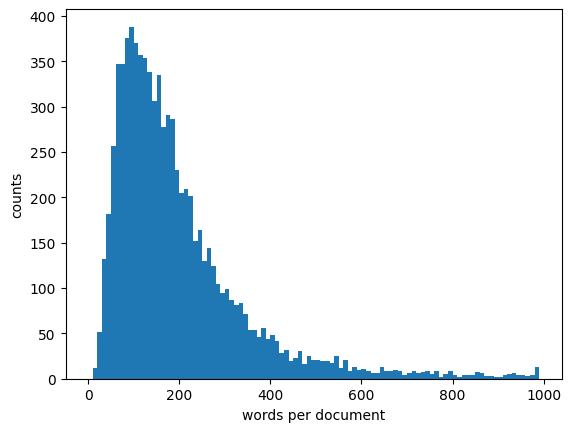

In [8]:
import matplotlib.pyplot as plt

plt.hist(total_words_per_document,bins=range(0,1000,10));
plt.xlabel('words per document');
plt.ylabel('counts');

#### Implement the distributed version using the `delayed` lazy execution

In [11]:
%%time

# initialize a word-per-document list
total_words_per_document = []

# count the number of words in each document
# using dask delayed 
for document in dataset:
    total_words_per_document.append(delayed(count_words)(document))

# calculate the total number of words in the dataset
# using dask delayed 
total_words_lazy = delayed(sum)(total_words_per_document)

CPU times: user 387 ms, sys: 40.3 ms, total: 427 ms
Wall time: 425 ms


In [12]:
%%time

# execute the tasks and retrieve the result
lazy_result = total_words_lazy.compute()

print(f"Total number of words in the dataset: {lazy_result}")

Total number of words in the dataset: 2038444
CPU times: user 2.11 s, sys: 46 ms, total: 2.16 s
Wall time: 13.9 s


#### Implement the distributed version using the `map` and `submit` eager execution

In [16]:
%%time

# count the number of words in each document
# using dask map 
total_words_per_document = client.map(count_words, dataset)

# calculate the total number of words in the dataset
# using dask submit 
total_words_eager = client.submit(sum, total_words_per_document)

CPU times: user 391 ms, sys: 8.31 ms, total: 399 ms
Wall time: 395 ms


In [17]:
# check the future object
total_words_eager

<Future: pending, key: sum-e2f96115f5fa8e2a09866bec1b937d5f>

In [18]:
eager_result = client.gather(total_words_eager)
print("Total number of words in the dataset: {}".format(eager_result))

Total number of words in the dataset: 2038444


## Exercise 4: Calculate the first $n$ Fibonacci numbers

Let's define the plain Python algorithm to evaluate the sequence of Fibonacci up to the $n$-th element:

Once again, let's start from some simple single-threaded Python code for this:

In [ ]:
def fibonacci_sequential(num):
    iteration = 1
    fibonacci = []
    if num <= 0:
        pass
    elif num == 1:
        fibonacci.append(1)
    elif num == 2:
        fibonacci.append(1)
        fibonacci.append(1)
    elif num > 2:
        fibonacci.append(1)
        fibonacci.append(1)
        while iteration < (num - 1):
            fibonacci.append(fibonacci[iteration] + fibonacci[iteration-1])
            iteration+=1
    return fibonacci

In [ ]:
# test it
n = 17

print(f"The first {n} fibonacci numbers are: {fibonacci_sequential(n)}")

#### Implement the same algorithm using the Dask lazy evaluation, with `delayed`, and inspect the task graph

In [ ]:
# in order to generalize the append
def append(arr = [], val = 0):
    if val != None:
        arr.append(val)
    return arr

def fibonacci_delayed(num):

    

In [ ]:
# test it
result = fibonacci_delayed(8)

In [ ]:
# visualize the graph
result.visualize(rankdir="LR")

In [ ]:
# compute
result.compute()

## Exercise 5: Monte Carlo Integration

Let's assume we want to integrate of a function via MonteCarlo technique, as you have discussed in LCP Module A.

Let's use the function $$f(x) =\sin^2{\left(\frac{1}{x(2-x)}\right)}$$ and let's integrate in the range $(0,2)$

In [ ]:
import numpy as np

def f(x):
    return (np.sin(1/(x*(2-x))))**2

x=np.linspace(-0.2,2.2,1000)

plt.figure(figsize=(16,6));
plt.plot(x,f(x),'grey','.');
plt.fill_between(x[np.where((x>0) & (x<2))],[1]*len(np.where((x>0) & (x<2))), alpha=0.2);
plt.fill_between(x[np.where((x>0) & (x<2))],f(x[np.where((x>0) & (x<2))]), alpha=0.2);
plt.vlines([0, 2], 0, 1, colors = ["k", "k"], linestyles = ["dashed", "dashed"],linewidths=[3,3],zorder=20);
plt.xlabel('x');
plt.ylabel('$f(x)$');

Create the single-thread Python code to execute this task, and evaluate the integral over N=100 000 points

In [ ]:
%%time
# Monte Carlo integration using Python's built-in random module

# number of points to use for integration
N = 100000

# list of counts for points that pass the function test
count = []

# function to check if a random point is passing
def pass_function():
    # generate a random x value between 0 and 2
    # generate a random y value between 0 and 1
    x = 2 * random.random()
    y = random.random()
    # check if the point (x, y) is under the curve defined by f(x)
    return 1 if y < f(x) else 0

# iterate over all points and count how many pass the function test
for i in range(N):
    count.append(pass_function())

# compute the integral by dividing the sum of the counts by the total number of points,
# and multiply by the width of the integration range (2)
I = 2 * sum(count) / N

# print the result
print(f"Integral = {I}")

#### Apply the minimal changes to the code to deploy the same integral computation on the Dask cluster using `delayed`

**NOTE**: Do NOT use 100 000 points in this case, but ___limit the computation to N=1 000 points___

In [ ]:
%%time
# Monte Carlo integration using Python's built-in random module

# number of points to use for integration
N = 1_000


We can even use Python **decorators** to declare that an entire function is going to be interpreted as `delayed`

```python
@dask.delayed
def my_delayed_function(arg):
    ...
    return val
```

In [ ]:
%%time
# Monte Carlo integration using Python's built-in random module

# import dask to use its delayed decorator @dask.delayed
import dask


Why we are getting worse performance with respect to the single-threaded execution?

The Dask code is slower than the plain Python code because of the **overhead** introduced by Dask itself. 

When we use Dask, we are creating a task graph that Dask needs to traverse in order to execute the computation. This involves additional computation and communication overhead between the scheduler and the workers, which can add some extra time compared to the plain Python version.

_Every delayed task per se has an overhead of a hundreds of microseconds. If thousands of computations are issued, the overhead can be substantial._

Additionally, we are using `delayed` to parallelize the computation in a way that doesn't take full advantage of Dask's parallelism capabilities. 

Specifically, we are creating a list of `delayed` objects and then computing them all at once using `delayed(sum)(count)`. 1000 `count` functions will be have to be executed as individual processes on the worker nodes.

This can be inefficient, as it's still running the loop in sequence and then aggregating the results in parallel. Instead, you could use Dask's `dask.bag` to parallelize the computation more effectively. 

Overall, when using Dask, it's important to make sure we're taking full advantage of its capabilities to parallelize the computation. In some cases, using Dask may not result in any performance gains and can even be slower than plain Python, if we don't take the time to rethink the task.

## Exercise 6: $\pi$ via MonteCarlo

We can re-run the evaluation of $\pi$ using the Monte Carlo technique as done during the Spark hands-on session. 

However, please note that so far with Dask, we are not creating data partitions yet. Instead, we are instructing Dask to run a simple task for each entry in our list, which results in a strong overhead.

Therefore, it's recommended to use a very limited number of points (start with around 10 and a maximum of around 100), and check the status of the job from the dashboard.

In [ ]:
%%time

import random

# set the number of points to use
num_points = 100

# list to hold the points inside the circle
points_in_circle = []

# function to check if a point is inside the circle
def in_circle():

    
    
# iterate over all the points and count how many are inside the circle



# count the number of points inside the circle
num_points_inside = 


# compute pi
pi = 4*num_points_inside/num_points

In [ ]:
# print result
print (f"pi = {pi}")

#### Use `delayed` to parallelize the computation

In [ ]:
%%time






In [ ]:
# print result
print (f"pi = {pi}")

#### Use `map` or `submit` to parallelize the computation using the Dask eager execution

With `submit` we have to be very careful...

Calling naively `client.map` with a function returning a random variable would imply returning all the times the same exact random value (we have _1 function_ executed 10000 times).

We can however instruct Dask that this function is in fact `inpure`.

```python
client.submit(your_function, pure=False)
```

An inpure function can return different output values for the same input.

This will guarantee us to get 10000 different random variables, but can be problematic for parallelization for Dask, as we can end up with unnecessary overhead and performance penalties.

In [ ]:
%%time






In [ ]:
# print result
print (f"pi = {pi}")

## Take-away message

Dask is a flexible tool allowing for the lazy or eager scheduling of our pure Pythonic code and tasks.

However, as we discussed, in general parallelization can be beneficial when the task involves a large amount of data or computationally intensive operations that can be split up into smaller chunks that can be executed concurrently. 

The simple functions used in this case are definitely not a good representation of a "heavy task".

Additionally, Dask Distributed can provide performance benefits when the computation is distributed across multiple nodes or machines, rather than just across a few CPU cores on a single machine (like in our case using Docker compose).

For all these reasons, it's always important to carefully evaluate the performance of our parallelized code and compare it to the performance of the single-threaded code.

## Stop client

In [ ]:
client.close()

Finally, use `docker compose down` to stop and clear all running containers.